In [1]:
import os
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
# import torch
# from torch import nn
# import pickle
import textwrap
from math import ceil
import tqdm.auto as tqdm


import sklearn as sk
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor

import confseq
from confseq import predmix, conjmix_bounded, betting

from Energy_ds.dataset import DataPrep, DataModule, EnergyDataset
from Energy_ds.config import SEASON, REGION, DatasetConfig

# from neural.train import LightningTrainer
# from neural.module import LightningModel, LightningWrapper
# from neural.mlp import MlpBlock, RMLP, MLPLayer
# from neural.config import TrainConfig

from risk import *
from algorithm import Hypothesis, ConfSeq

pd.set_option('display.max_columns', None)
sns.set_palette('viridis')


In [2]:
class SubplotGenerator:
    def __init__(self, rows, columns, dpi=200, **kwargs):
        self.fig, self.axes = plt.subplots(rows, columns, dpi=dpi, **kwargs)
        self.rows = rows
        self.columns = columns
        self.current_row = 0
        self.current_col = 0

    def __iter__(self):
        self.current_row = 0
        self.current_col = 0
        return self

    def __next__(self) -> plt.Axes:
        if self.current_row >= self.rows:
            raise StopIteration
        ax = self.axes[self.current_row, self.current_col]
        self.current_col += 1
        if self.current_col >= self.columns:
            self.current_col = 0
            self.current_row += 1
        return ax
    
    @property
    def current_ax(self) -> plt.Axes:
        return self.axes[self.current_row, self.current_col]

In [3]:
class HoffConf(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = predmix.predmix_hoeffding_cs(x, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs
    
    @staticmethod
    def standardise(x):
        return (x - x.min()) / (x.max() - x.min())
    

class EmpbernConf(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val=min_val, max_val=max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)

        lower_cs, higher_cs = predmix.predmix_empbern_twosided_cs(x, self.conf_lvl, running_intersection=False)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs
    

class EmpbernConjmix(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        # std = x.std()
        lower_cs, higher_cs = conjmix_bounded.conjmix_empbern_twosided_cs(x, 1/12, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs


class EmpbernBetting(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = betting.betting_cs(x, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs

In [4]:
class H0(Hypothesis):
    def __init__(self, tolerance:float, lower_bound:ConfSeq, upper_bound:ConfSeq):
        super().__init__(tolerance, lower_bound, upper_bound)
    
    @property
    def source_upper(self):
        return self.source_upper_cs[-1] * self.tolerance
    
    @property
    def target_lower(self):
        return self.target_lower_cs
    


In [5]:
class DeployedModel:
    def __init__(
        self,
        model: RandomForestRegressor,
        hyp_tests: list[tuple[Hypothesis, Risk]],
        past:int=np.inf
    ):
        self.model = model
        self.hyp_tests = hyp_tests
        self.past = past
        
        self.input_seq = None
        self.label_seq = None
        self.pred_seq = None

        self.collector:tuple[Hypothesis, Risk] = None
        self.retrainer:tuple[Hypothesis, Risk] = None
        self.collect_from_idx:int = None

        self.train_features = None
        self.train_labels = None
        self.sample_weights = None
        self.retrain:bool = True
        self.retrain_intervals:list[tuple[int, int]] = []

    def update(self, features:np.ndarray, labels: np.ndarray, to_target:bool=True) -> None:
        # features = features.reshape(-1, 1)
        preds = self.model.predict(features)
        # update input, label and prediction sequences
        self.input_seq = self._append_seq(features, self.input_seq)
        self.label_seq = self._append_seq(labels, self.label_seq)
        self.pred_seq = self._append_seq(preds, self.pred_seq)
        
        past = max(len(self.input_seq) - self.past, 0)
        tr_input, tr_label, tr_pred, = self.input_seq[past:], self.label_seq[past:], self.pred_seq[past:]
        # update targed confidence bounds
        for hyp, risk in self.hyp_tests:
            val = risk(tr_input, tr_label, tr_pred)
            if not np.isnan(val): # ignore nan values
                hyp.add_observations(val, to_target=to_target)
                # hyp.test(val) # same results without testing every time
        
        if to_target and self.retrain:
            if self.collector is not None and self.collect_from_idx is None:            
                hyp, risk = self.collector
                valid = hyp.test()
                if not valid:
                    self.collect_from_idx = len(self.input_seq)
                    print(f"Collecting from index: {self.collect_from_idx}")
            
            if self.retrainer is not None and self.collect_from_idx is not None:
                if len(self.input_seq) - self.collect_from_idx >= 2*self.past:
                    hyp, risk = self.retrainer
                    valid = hyp.test()
                    if not valid: # crossed the second threshold
                        print("retrain threshold crossed at index: ", len(self.input_seq))                        
                        x, y = self.input_seq[self.collect_from_idx:], self.label_seq[self.collect_from_idx:]
                        self.train_features = self._append_seq(x, self.train_features, dim=0)
                        self.train_labels = self._append_seq(y, self.train_labels, dim=0)
                        
                        # calculate new sample weights
                        sample_weights = self.sample_weights.copy() * 0.5
                        self.sample_weights = np.ones(len(self.train_labels))
                        self.sample_weights[:len(sample_weights)] = sample_weights

                        self.fit()
                        self.retrain_intervals.append((self.collect_from_idx, len(self.input_seq)))
                        self.collect_from_idx = None
                        print("Retrained Model with new data ")

    def test(self):
        test_results = []
        for hyp, _ in self.hyp_tests:
            res = hyp.test()
            test_results.append(res)
        return all(test_results)

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, train_ds:EnergyDataset|None=None):
        # fit model
        if train_ds is not None:
            x, y = train_ds.features, train_ds.labels
            self.train_features = x
            self.train_labels = y
            self.sample_weights = np.ones(len(y))
        else:
            x, y = self.train_features, self.train_labels
        
        # mask = self.sample_weights > 0.3 ** 4
        # x, y = x[mask], y[mask]
        print(f"train_features shape: {x.shape}, train_labels shape: {y.shape}")
        self.model = self.model.fit(x, y)
    
    def calibrate(self, calibration_ds:EnergyDataset, batch_size:int=1):
        calibration_ds.set_batch_size(batch_size)
        for batch_idx, (x, y) in enumerate(calibration_ds):
            self.update(x, y, to_target=False)

        for hyp, risk in self.hyp_tests:
            risk_list = hyp.source_bound._risk_seq
            min_val, max_val = self.infer_bounds(hyp, risk_seq=risk_list, gamma=5, set_bounds=True)
            print(f"Inferred {risk} Bounds: min_val: {min_val}, max_val: {max_val} :: risk mean: {risk_list.mean()}, std: {risk_list.std()}")
            hyp.calc_source_upper_cs(risk_list)
        
    def set_retraining_tests(self, collector:tuple[Hypothesis, Risk], retrainer:tuple[Hypothesis, Risk]):
        self.collector = collector
        self.retrainer = retrainer
        self.collect_from_idx = None

        self.hyp_tests.append(collector)
        self.hyp_tests.append(retrainer)

    def to_dataframe(self):
        results = []
        for hyp, risk in self.hyp_tests:
            res = hyp.to_dataframe()
            # res['GT'] = self.label_seq
            res['risk'] = risk.__class__.__name__
            res['hyp'] = hyp.__class__.__name__
            results.append(res)
        return pd.concat(results, axis=0, ignore_index=True)
    
    def _append_seq(self, x:np.ndarray|float, seq:np.ndarray, dim:int=0) -> np.ndarray:
        """
        append the input x to the sequence.
        parameters:
            x (np.ndarray): The input array of shape (n_samples) or a float if x is a single sample.
            seq (np.ndarray): The sequence to append to.
        """
        if isinstance(x, float):
            x = np.asanyarray([x])
        
        if seq is None:
            return x

        new_seq = np.concatenate((seq, x), axis=dim)
        return new_seq

    def reset(self, source:bool=True, target:bool=True):
        if target:
            self.input_seq = None
            self.label_seq = None
            self.pred_seq = None

        for hyp, risk in self.hyp_tests:
            hyp.reset(source=source, target=target)
        
    def infer_bounds(self, hyp:Hypothesis, risk_seq:np.ndarray, gamma:float=2, set_bounds:bool=False):
        std = (risk_seq).std()

        min_val = risk_seq.min() - std * gamma
        min_val = max(min_val, 0)
        max_val = risk_seq.max() + std * gamma

        if set_bounds:
            # print(f"Setting Bounds: min_val: {min_val}, max_val: {max_val}")
            hyp.set_bounds(min_val, max_val)
        
        return min_val, max_val
    

In [6]:
class Experiment:
    def __init__(
        self,
        model,
        batch_size=1, # in hours (will load n_regions * batch_size)
        test_every=1, # calculate confidence intervals and test hypotheses every n batches
    ):
        self.model: DeployedModel = model
        self.batch_size: int = batch_size
        self.test_every: int = test_every

    def train(self, train_ds: EnergyDataset):
        self.model.fit(train_ds)
    
    def calibrate(self, calibration_ds: EnergyDataset):
        self.model.calibrate(calibration_ds, batch_size=self.batch_size)
    
    def eval(self, val_ds: EnergyDataset):
        preds = self.model.predict(val_ds.features)
        mse = sk.metrics.mean_squared_error(val_ds.labels, preds)
        mae = sk.metrics.mean_absolute_error(val_ds.labels, preds)
        return mse, mae

    def test(self, test_ds: EnergyDataset):
        test_ds.set_batch_size(self.batch_size)
        ds_len = ceil(len(test_ds) / test_ds.batch_size)
        for batch_idx, (x, y) in tqdm.tqdm(enumerate(test_ds), desc="Testing", total=ds_len):
            self.model.update(x, y)
            # if batch_idx % self.test_every == 0:
            #     self.model.test()
        self.model.test()
        return self.model.to_dataframe()

In [7]:
path = "Hourly_Energy_Consumption/AEP_hourly.csv"
all_paths = ['Hourly_Energy_Consumption/AEP_hourly.csv',
            'Hourly_Energy_Consumption/COMED_hourly.csv',
            'Hourly_Energy_Consumption/DAYTON_hourly.csv',
            'Hourly_Energy_Consumption/DEOK_hourly.csv',
            'Hourly_Energy_Consumption/DOM_hourly.csv',
            'Hourly_Energy_Consumption/DUQ_hourly.csv',
            'Hourly_Energy_Consumption/EKPC_hourly.csv',
            'Hourly_Energy_Consumption/FE_hourly.csv',
            'Hourly_Energy_Consumption/NI_hourly.csv',
            'Hourly_Energy_Consumption/PJME_hourly.csv',
            'Hourly_Energy_Consumption/PJMW_hourly.csv',
            # 'Hourly_Energy_Consumption/PJM_Load_hourly.csv',
            # 'Hourly_Energy_Consumption/est_hourly.paruqet',
            # 'Hourly_Energy_Consumption/pjm_hourly_est.csv'
            ]

# Analyze Data

In [8]:
prep = DataPrep(*all_paths)
data = prep.data

In [9]:
data['Region'] = data['Region'].apply(lambda x: REGION(x).name)
data['Epoch'] = data['Datetime'].apply(lambda x: x.timestamp())
grouped = data.groupby(by=['Region']).agg(['min', 'max', 'mean', 'std'])
grouped


Datetime                                           \
                       min        max                          mean   
Region                                                                
AEP    2004-10-01 01:00:00 2018-08-03 2011-09-02 03:17:01.553025024   
COMED  2011-01-01 01:00:00 2018-08-03 2014-10-17 14:11:46.389762048   
DAYTON 2004-10-01 01:00:00 2018-08-03 2011-09-02 03:33:26.471243008   
DEOK   2012-01-01 01:00:00 2018-08-03 2015-04-18 01:50:20.461040128   
DOM    2005-05-01 01:00:00 2018-08-03 2011-12-17 03:06:26.928194560   
DUQ    2005-01-01 01:00:00 2018-08-03 2011-10-18 03:17:46.200826368   
EKPC   2013-06-01 01:00:00 2018-08-03 2016-01-01 12:59:54.679490048   
FE     2011-06-01 01:00:00 2018-08-03 2015-01-01 01:57:54.549097984   
NI     2004-05-01 01:00:00 2011-01-01 2007-08-31 23:47:25.632164352   
PJME   2002-01-01 01:00:00 2018-08-03 2010-04-18 03:25:25.999202048   
PJMW   2002-04-01 01:00:00 2018-08-03 2010-06-02 03:39:50.656816128   

                                          MW                         \
                                std      min      max          mean   
Region                                                                
AEP    1459 days 00:04:35.416530256   9581.0  25695.0  15499.513717   
COMED   799 days 21:58:33.102316120   7237.0  23753.0  11420.152112   
DAYTON 1458 days 23:51:35.157888992    982.0   3746.0   2037.851140   
DEOK    694 days 13:03:11.442351240    907.0   5445.0   3105.096486   
DOM    1397 days 19:15:23.708513376   1253.0  21651.0  10949.203625   
DUQ    1432 days 10:34:50.462659536   1014.0   3054.0   1658.820296   
EKPC    545 days 07:12:02.646685136    514.0   3490.0   1464.218423   
FE      756 days 07:49:31.117741040      0.0  14032.0   7792.159064   
NI      703 days 05:04:59.498234760   7003.0  23631.0  11701.682943   
PJME   1748 days 20:09:48.026926592  14544.0  62009.0  32080.222831   
PJMW   1722 days 20:27:36.657026176    487.0   9594.0   5602.375089   

                     Year                              Month                \
                std   min   max         mean       std   min max      mean   
Region                                                                       
AEP     2591.399065  2004  2018  2011.169988  4.011177     1  12  6.500309   
COMED   2304.139517  2011  2018  2014.309172  2.197997     1  12  6.332586   
DAYTON   393.403153  2004  2018  2011.170019  4.011153     1  12  6.500326   
DEOK     599.859026  2012  2018  2014.811098  1.910792     1  12  6.303261   
DOM     2413.946569  2005  2018  2011.459088  3.845824     1  12  6.514025   
DUQ      301.740640  2005  2018  2011.302911  3.926464     1  12  6.416989   
EKPC     378.868404  2013  2018  2015.500375  1.543446     1  12  6.525345   
FE      1331.268006  2011  2018  2014.499857  2.107653     1  12  6.523778   
NI      2371.498701  2004  2011  2007.148246  1.931479     1  12  6.722224   
PJME    6464.012166  2002  2018  2009.801026  4.791823     1  12  6.435948   
PJMW     979.142872  2002  2018  2009.918691  4.730344     1  12  6.502835   

                 Day                          Hour                           \
             std min max       mean       std  min max       mean       std   
Region                                                                        
AEP     3.461454   1  31  15.723220  8.802246    0  23  11.501587  6.921830   
COMED   3.424633   1  31  15.715656  8.803733    0  23  11.500880  6.922073   
DAYTON  3.461476   1  31  15.723100  8.802228    0  23  11.501546  6.921810   
DEOK    3.420165   1  31  15.714699  8.804815    0  23  11.500701  6.922139   
DOM     3.417708   1  31  15.725869  8.803861    0  23  11.501459  6.921836   
DUQ     3.436416   1  31  15.721117  8.801321    0  23  11.501495  6.921829   
EKPC    3.392182   1  31  15.713416  8.807696    0  23  11.500309  6.922271   
FE      3.408244   1  31  15.720982  8.806671    0  23  11.500795  6.922095   
NI      3.402549   1  31  15.736647  8.802695    0  23  11.502207 

In [10]:
# g = sns.relplot(data=data, x='Datetime', y='MW', hue='Region', kind='line', aspect=3, linewidth = 0.8)
# g.figure.suptitle(template=f"Energy Consumption in each region, by season")
# g.figure.set_dpi(200)

![Dataset Visualization](/home/guycoh/new/ReliabilityInML_Project/imgs/dataset_vis.png)

# Run Experiments

In [11]:
train_config = DatasetConfig(
    past_hours=[1,2,3,6, 12, 24, 36],
    years=(2012, 2014),
    region=[REGION.AEP, REGION.COMED, REGION.DOM],
)

test_config = DatasetConfig(**train_config.__dict__)
test_config.years = (2014, 2019)


In [12]:
train_ds = EnergyDataset(all_paths, train_config)
test_ds = EnergyDataset(all_paths, test_config)

columns = train_ds.features_df.columns

In [13]:
data = pd.concat([train_ds.features_df, train_ds.labels_df], axis=1)
data['Season'] = data['Season'].apply(lambda x: SEASON(x).name)
data['Region'] = data['Region'].apply(lambda x: REGION(x).name)

data.describe()

Year         Month           Day          Hour  Week_Number  \
count  52619.000000  52619.000000  52619.000000  52619.000000      52619.0   
mean    2012.499325      6.519622     15.740892     11.502195    26.464566   
std        0.500004      3.449391      8.803838      6.921691     15.06578   
min     2012.000000      1.000000      1.000000      0.000000          1.0   
25%     2012.000000      4.000000      8.000000      6.000000         13.0   
50%     2012.000000      7.000000     16.000000     12.000000         26.0   
75%     2013.000000     10.000000     23.000000     18.000000         40.0   
max     2013.000000     12.000000     31.000000     23.000000         52.0   

          MW_at_-1H     MW_at_-2H     MW_at_-3H     MW_at_-6H    MW_at_-12H  \
count  52619.000000  52619.000000  52619.000000  52619.000000  52619.000000   
mean    7943.056443  13011.726772  16977.869933  14997.962903  15784.774986   
std     5493.323136  13722.530068  11187.536905  12801.020825  12128.722028   
min     1655.000000   1154.000000   4994.000000   1155.000000   1167.000000   
25%     3395.000000   2205.000000   8361.500000   3178.500000   6869.000000   
50%     5413.000000   5413.000000  11379.000000  10408.000000  10314.000000   
75%    13564.000000  27217.000000  27217.000000  27217.000000  27216.500000   
max    23320.000000  59122.000000  59122.000000  59122.000000  59122.000000   

         MW_at_-24H    MW_at_-36H            MW  
count  52619.000000  52619.000000  52619.000000  
mean   12957.444098  13244.334632  12538.654079  
std    11400.373121   7855.576965   3081.219186  
min      514.000000   1155.000000   6287.000000  
25%     3178.000000   9555.500000  10158.000000  
50%     9596.000000  11807.000000  12059.000000  
75%    17691.500000  15179.000000  14645.000000  
max    58999.000000  59122.000000  23603.000000

In [14]:
# g = sns.relplot(data=data, x='Hour', y='MW', hue='Season', col='Year', row='Region', kind='line', palette='viridis')
# g.figure.suptitle(f"Energy Consumption By Hour, per year and region", fontsize=16)
# g.figure.set_dpi(200)
# g.tight_layout()


## Multiple Risk Monitoring

In [15]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor


rf = ExtraTreesRegressor(
    n_estimators=400,
    min_samples_split=0.01,
    min_samples_leaf=0.003,
    n_jobs=-1,
    random_state=42,
    # verbose=1,
)



In [16]:
class RiskFilter2(RiskFilter):
    def __init__(self, risk:Risk, feature_cols:list[str], cfg:DatasetConfig, name:str=''):
        self.config = cfg
        super().__init__(risk, feature_cols, self.config.conditions, name)

class season_filter:
    def __init__(self, season:SEASON) -> None:
        self.season = season
    
    def __call__(self, df:pd.DataFrame) -> pd.Series:
        if df.iloc[-1]['Season']!=self.season.value:
            return False
        return df['Season']!=-18

In [17]:
tests = []

mae_risk = MAE()
hyp_test_1 = H0(tolerance=1.1,
                lower_bound=EmpbernConjmix(0.05),
                upper_bound=EmpbernConjmix(0.05)
                )
tests.append((hyp_test_1, mae_risk))

for season in SEASON:
    mae = MAE()
    filter_risk = RiskFilter(mae, columns, season_filter(season), name=season.name)
    hyp_test_3 = H0(tolerance=1.1,
                    lower_bound=EmpbernConjmix(0.05),
                    upper_bound=EmpbernConjmix(0.05)
                    )
    tests.append((hyp_test_3, filter_risk))

In [18]:
past = len(train_ds.features_df['Region'].unique())*24*30
model = DeployedModel(rf, tests, past=past)

In [19]:
experiment = Experiment(model, batch_size=24*1)

In [20]:
experiment.model.reset(source=True, target=True)

In [21]:
experiment.train(train_ds)

mse, mae = experiment.eval(train_ds)
print(f"Train MSE: {mse}, MAE: {mae}")

mse, mae = experiment.eval(test_ds)
print(f"Calibration MSE: {mse}, MAE: {mae}")

train_features shape: (52619, 14), train_labels shape: (52619,)
Train MSE: 640899.6347326093, MAE: 583.8797524406419
Calibration MSE: 860332.6578148748, MAE: 684.1694526997773


In [22]:
experiment.calibrate(train_ds)

Inferred MAE Bounds: min_val: 0, max_val: 1946.1456167420667 :: risk mean: 584.1149936368273, std: 164.16603868028724
Inferred RiskFilter(MAE, SPRING) Bounds: min_val: 0, max_val: 1069.0398214648953 :: risk mean: 475.7103717085754, std: 75.73826904370682
Inferred RiskFilter(MAE, SUMMER) Bounds: min_val: 0, max_val: 1853.8554618961093 :: risk mean: 797.4942730750614, std: 145.70800771109575
Inferred RiskFilter(MAE, FALL) Bounds: min_val: 0, max_val: 1287.3431002857715 :: risk mean: 487.14756156679147, std: 95.602796432407
Inferred RiskFilter(MAE, WINTER) Bounds: min_val: 135.84919735693762, max_val: 1115.5500144524472 :: risk mean: 574.9035884153343, std: 66.84742189815141


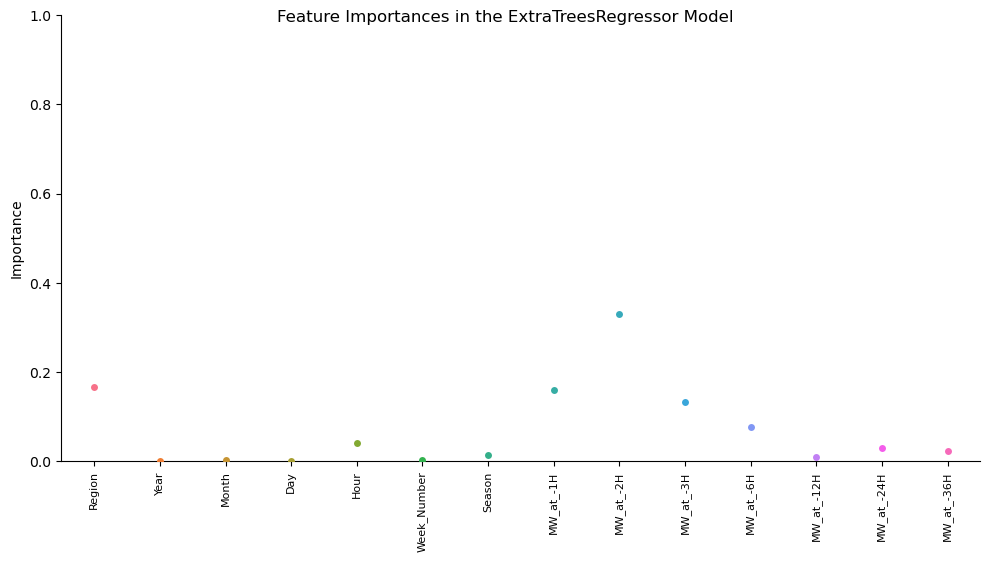

In [23]:
# # Show feature inportances
feature_cols = train_ds.features_df.columns
featureimportances = pd.DataFrame(experiment.model.model.feature_importances_.reshape(1,-1), columns=feature_cols)
# fig, ax = plt.subplots(dpi=200, figsize=(10, 5))
g = sns.catplot(data=featureimportances, aspect=2)
g.set_xticklabels(rotation=90, fontsize=8)
g.figure.suptitle(f"Feature Importances in the {experiment.model.model.__class__.__name__} Model")
g.set_ylabels("Importance")
g.set(ylim=(0, 1))

In [24]:
def run_experiment(experiment:Experiment, ds:EnergyDataset, retrain:bool=False, n_cols:int=4, **kwargs):
    config = ds.config
    experiment.model.reset(source=False, target=True)
    experiment.model.past = len(ds.features_df['Region'].unique())*24*30
    experiment.model.retrain = retrain
    
    result = experiment.test(ds)
    n_rows = ceil(len(experiment.model.hyp_tests) / n_cols)
    plot_gen = SubplotGenerator(n_rows, n_cols, figsize=(10*n_cols, 7*n_rows))
    fig: plt.Figure = plot_gen.fig
    line1 = f"Confidence Intervals for {experiment.model.model.__class__.__name__} Model"
    line2 = textwrap.fill(str(config), width=100*n_cols)
    fig.suptitle(line1 + '\n' + line2, fontsize=12)

    for idx, ((hyp, test_risk), ax) in enumerate(zip(experiment.model.hyp_tests, plot_gen)):
        # ax = ax_gen.__next__()
        g = hyp.plot(layout='constrained', ax=ax, **kwargs)
        title = f"Tolerance: {hyp.tolerance}, Risk={test_risk}"
        title = textwrap.fill(title, width=100)
        g.set_title(title, fontsize=10)
        g.legend(fontsize=8)  # Adjust legend font size and position

        g.autoscale(enable=True, axis='both')
        if retrain and idx==0:
            for idx, (start, end) in enumerate(experiment.model.retrain_intervals):
                start /= experiment.batch_size * len(ds.features_df['Region'].unique())
                end /= experiment.batch_size * len(ds.features_df['Region'].unique())
                g.fill_betweenx([0,25+idx], start, end, color='k', alpha=0.2, label=f"{idx}")
            # fig.axvspan(start, end, color='r', alpha=0.2, label=f"{idx}")
    # fig.tight_layout()
    return result

Testing:   0%|          | 0/731 [00:00<?, ?it/s]

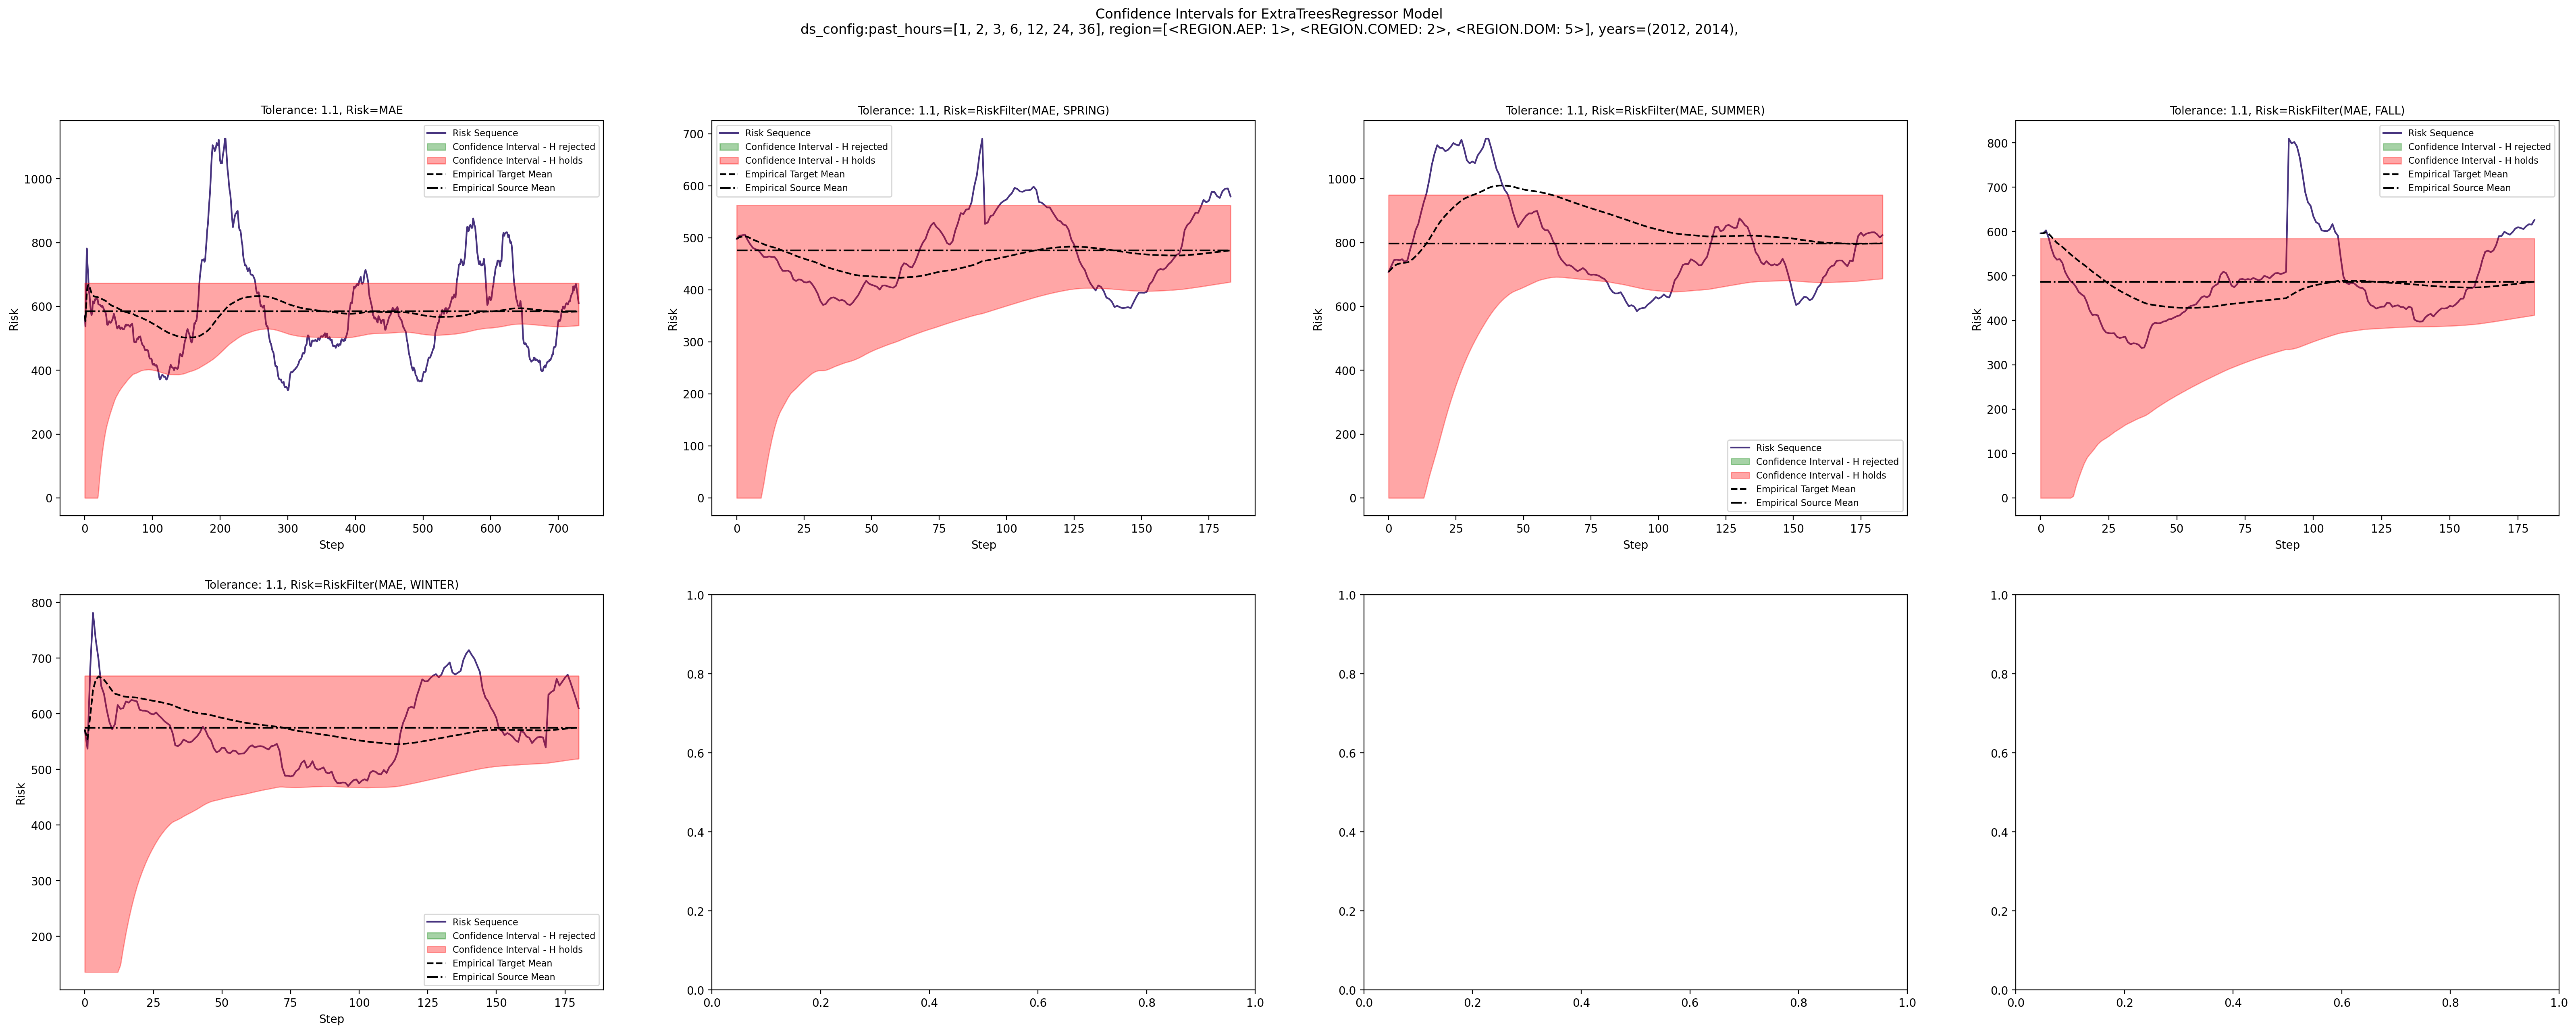

In [25]:
test_result = run_experiment(experiment, train_ds, retrain=False)

Testing:   0%|          | 0/1675 [00:00<?, ?it/s]

Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x to [135.84919735693762, 1115.5500144524472]
Clipping x

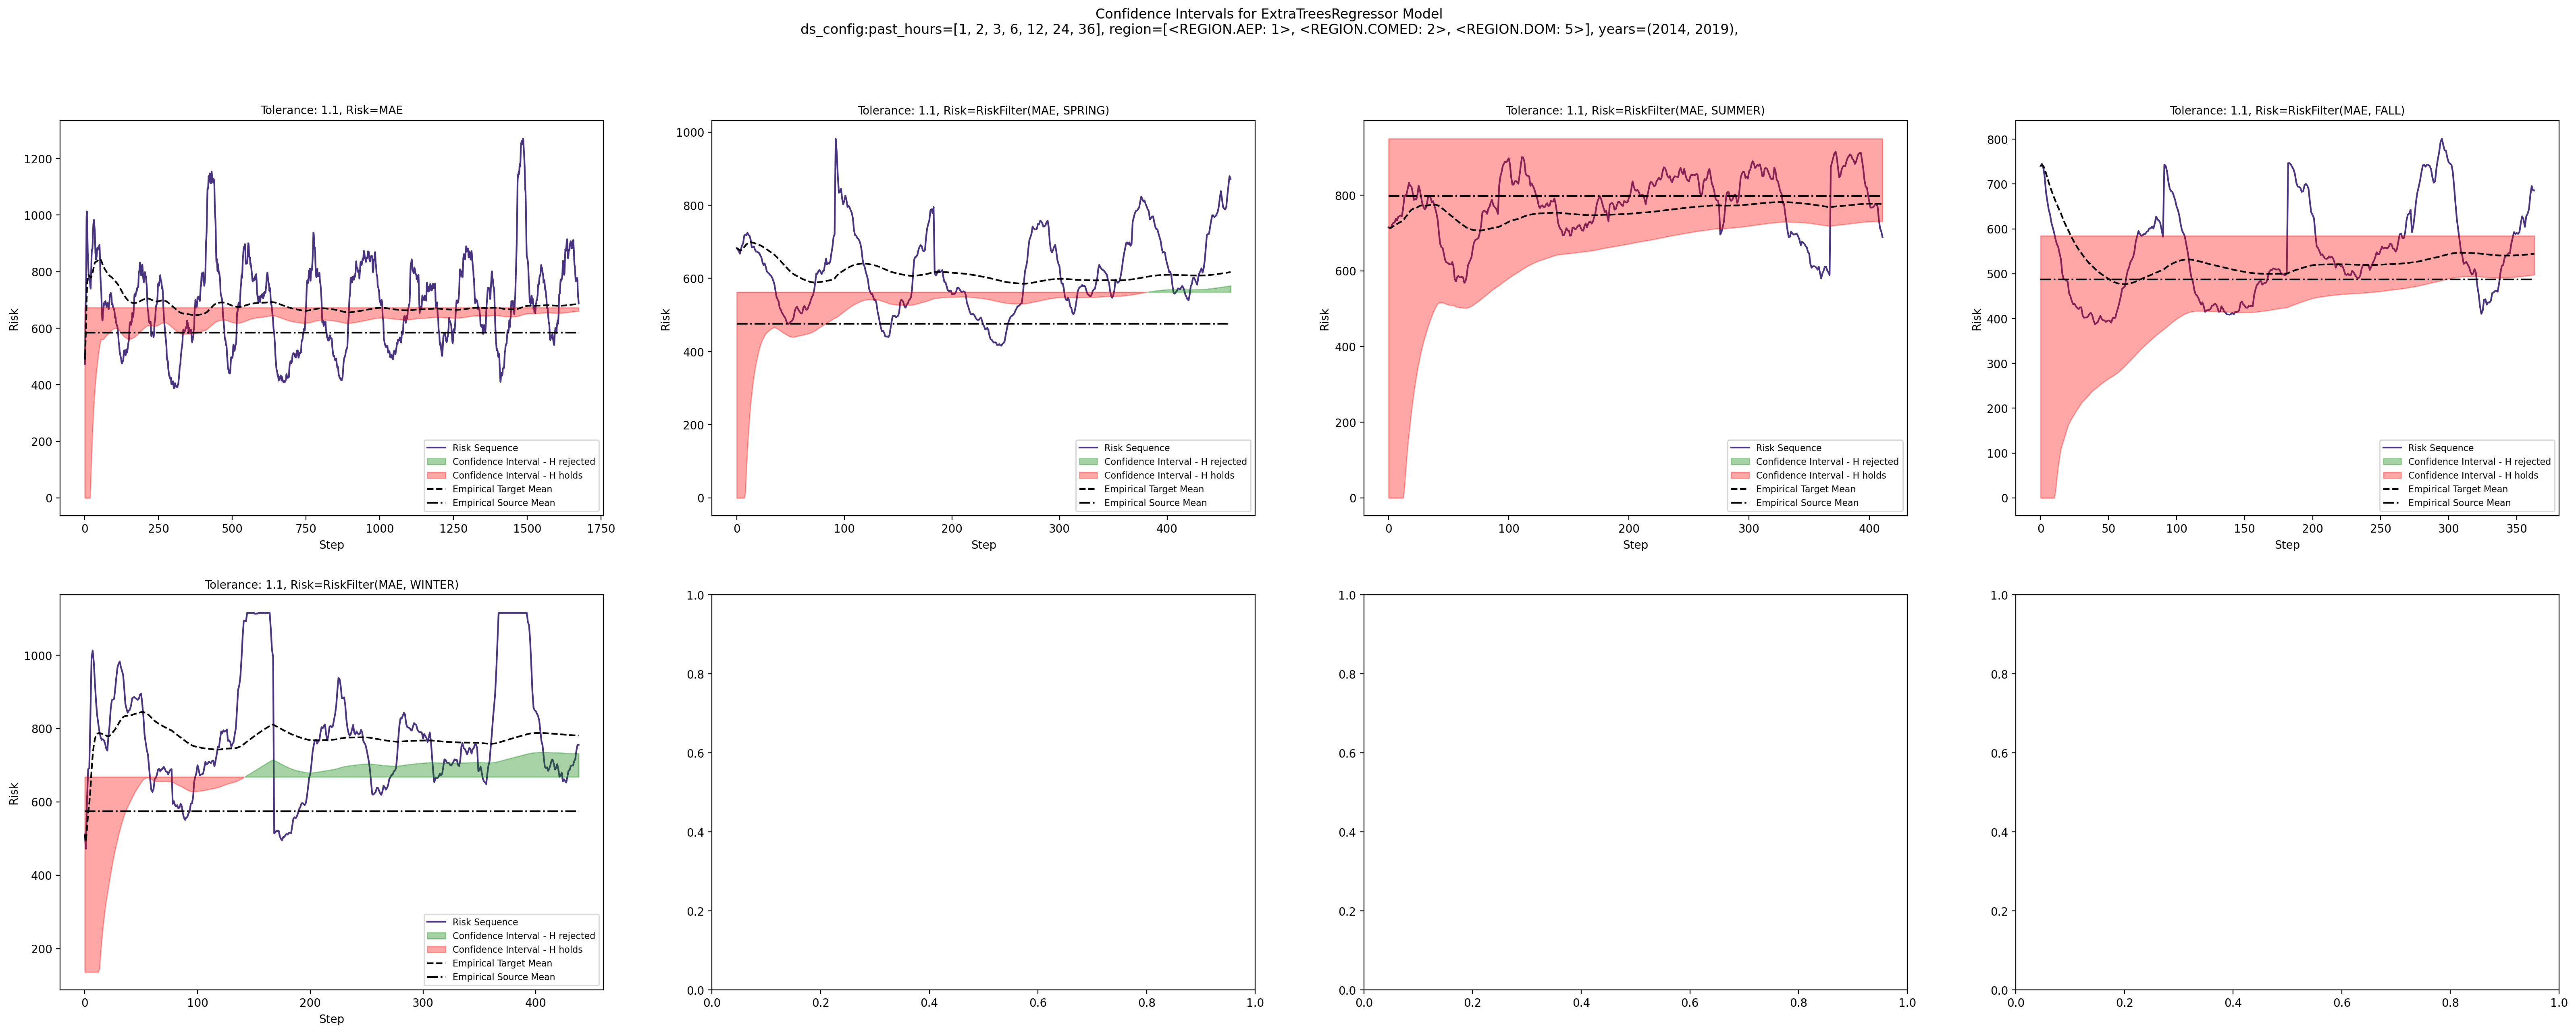

In [26]:
# experiment.train(train_ds)
# test_cfg = DatasetConfig(**train_config.__dict__)
# test_cfg.years = (2014, 2019)
# test_ds = EnergyDataset(all_paths, test_cfg)
test_result = run_experiment(experiment, test_ds, retrain=False)

## Retraining

In [27]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(7, 5, 3),
    activation='relu',
    learning_rate='adaptive',
    max_iter=100,
    shuffle=False,
    warm_start=False,
    random_state=42,
    verbose=True,
)

rf = BaggingRegressor(
    estimator=mlp,
    n_estimators=5,
    bootstrap=True,
    bootstrap_features=False,
    random_state=42,
    verbose=1,
    # warm_start=True,
    n_jobs=-1,
)

In [28]:
tests = []

mae_risk = MAE()
hyp_test_1 = H0(tolerance=1.1,
                lower_bound=EmpbernConjmix(0.05),
                upper_bound=EmpbernConjmix(0.05)
                )
tests.append((hyp_test_1, mae_risk))

for season in SEASON:
    mae = MAE()
    filter_risk = RiskFilter(mae, columns, season_filter(season), name=season.name)
    hyp_test_3 = H0(tolerance=1.1,
                    lower_bound=EmpbernConjmix(0.05),
                    upper_bound=EmpbernConjmix(0.05)
                    )
    tests.append((hyp_test_3, filter_risk))

In [29]:
past = len(train_ds.features_df['Region'].unique())*24*30
model = DeployedModel(rf, tests, past=past)

In [30]:
collector = (H0(tolerance=1.05, lower_bound=EmpbernConjmix(0.05), upper_bound=EmpbernConjmix(0.05)), MAE())
retrainer = (H0(tolerance=1.15, lower_bound=EmpbernConjmix(0.05), upper_bound=EmpbernConjmix(0.05)), MAE())
model.set_retraining_tests(collector, retrainer)

In [31]:
experiment = Experiment(model, batch_size=24*1)

In [32]:
experiment.model.reset(source=True, target=True)

In [33]:
experiment.train(train_ds)

mse, mae = experiment.eval(train_ds)
print(f"Train MSE: {mse}, MAE: {mae}")

mse, mae = experiment.eval(test_ds)
print(f"Calibration MSE: {mse}, MAE: {mae}")

train_features shape: (52619, 14), train_labels shape: (52619,)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Iteration 1, loss = 50236126.69396050
Iteration 1, loss = 40576874.34220070
Iteration 1, loss = 10452144.59771392
Iteration 1, loss = 102510204.81613597
Iteration 2, loss = 9194087.75722149
Iteration 2, loss = 884046.94498219
Iteration 2, loss = 812527.60596643
Iteration 1, loss = 12082471.65876445
Iteration 3, loss = 713276.51916637
Iteration 3, loss = 4717105.36923893
Iteration 3, loss = 651260.10967236
Iteration 2, loss = 10851155.67746966
Iteration 4, loss = 2495120.37931863
Iteration 4, loss = 664245.83584854
Iteration 4, loss = 636158.36693212
Iteration 2, loss = 1002786.72566147
Iteration 5, loss = 1398515.61325764
Iteration 5, loss = 643236.73698216
Iteration 5, loss = 628258.04252697
Iteration 3, loss = 1197649.26676248
Iteration 6, loss = 629115.76387597
Iteration 6, loss = 984102.85915048
Iteration 6, loss = 621277.25420907
Iteration 3, loss = 757926.87527588
Iteration 7, loss = 616319.81989663
Iteration 7, loss = 871421.25146618
Iteration 7, loss = 613559.33247338
Iteration

/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.5s


Iteration 56, loss = 358900.38249937
Iteration 56, loss = 283234.49898159
Iteration 99, loss = 284423.19531116
Iteration 57, loss = 355554.91098898
Iteration 100, loss = 284319.33565408
Iteration 57, loss = 282534.61467868
Iteration 58, loss = 352468.18505114
Iteration 58, loss = 281781.32321357


/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 59, loss = 349642.79769823
Iteration 59, loss = 281103.31865706
Iteration 60, loss = 347196.16282421
Iteration 60, loss = 280465.08168036
Iteration 61, loss = 345131.24620665
Iteration 61, loss = 279713.42650337
Iteration 62, loss = 343312.10204711
Iteration 62, loss = 279058.14752841
Iteration 63, loss = 341775.13959355
Iteration 63, loss = 278443.86382252
Iteration 64, loss = 340478.25292416
Iteration 64, loss = 277895.32860695
Iteration 65, loss = 339352.77085611
Iteration 65, loss = 277302.36794738
Iteration 66, loss = 338334.66625806
Iteration 66, loss = 276735.51083288
Iteration 67, loss = 337437.19724494
Iteration 67, loss = 276251.63012008
Iteration 68, loss = 336662.03884860
Iteration 68, loss = 275693.01944935
Iteration 69, loss = 335982.20612953
Iteration 69, loss = 275176.68191726
Iteration 70, loss = 335331.15615886
Iteration 70, loss = 274695.44830080
Iteration 71, loss = 334706.87086624
Iteration 71, loss = 274198.58392300
Iteration 72, loss = 334119.44217545
I

/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   17.6s finished


Iteration 100, loss = 264432.13713384


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


Train MSE: 572650.125, MAE: 555.1072387695312
Calibration MSE: 928990.8125, MAE: 704.3803100585938


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished


In [34]:
experiment.calibrate(train_ds)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

Inferred MAE Bounds: min_val: 0, max_val: 1503.8411712646484 :: risk mean: 557.2711181640625, std: 117.60325622558594
Inferred RiskFilter(MAE, SPRING) Bounds: min_val: 40.82233428955078, max_val: 926.9394760131836 :: risk mean: 461.7480163574219, std: 66.23998260498047
Inferred RiskFilter(MAE, SUMMER) Bounds: min_val: 119.7202377319336, max_val: 1278.5066299438477 :: risk mean: 674.0155029296875, std: 84.35419464111328
Inferred RiskFilter(MAE, FALL) Bounds: min_val: 0, max_val: 1207.988624572754 :: risk mean: 489.9617919921875, std: 93.67633819580078
Inferred RiskFilter(MAE, WINTER) Bounds: min_val: 109.21160125732422, max_val: 1287.5319290161133 :: risk mean: 603.3792114257812, std: 74.3414077758789
Inferred MAE Bounds: min_val: 0, max_val: 1503.8411712646484 :: risk mean: 557.2711181640625, std: 117.60325622558594
Inferred MAE Bounds: min_val: 0, max_val: 1503.8411712646484 :: risk mean: 557.2711181640625, std: 117.60325622558594


In [35]:
print(experiment.model.collector[0].source_upper)
print(experiment.model.retrainer[0].source_upper)

606.4635525076529
664.2219860798103


Testing:   0%|          | 0/731 [00:00<?, ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

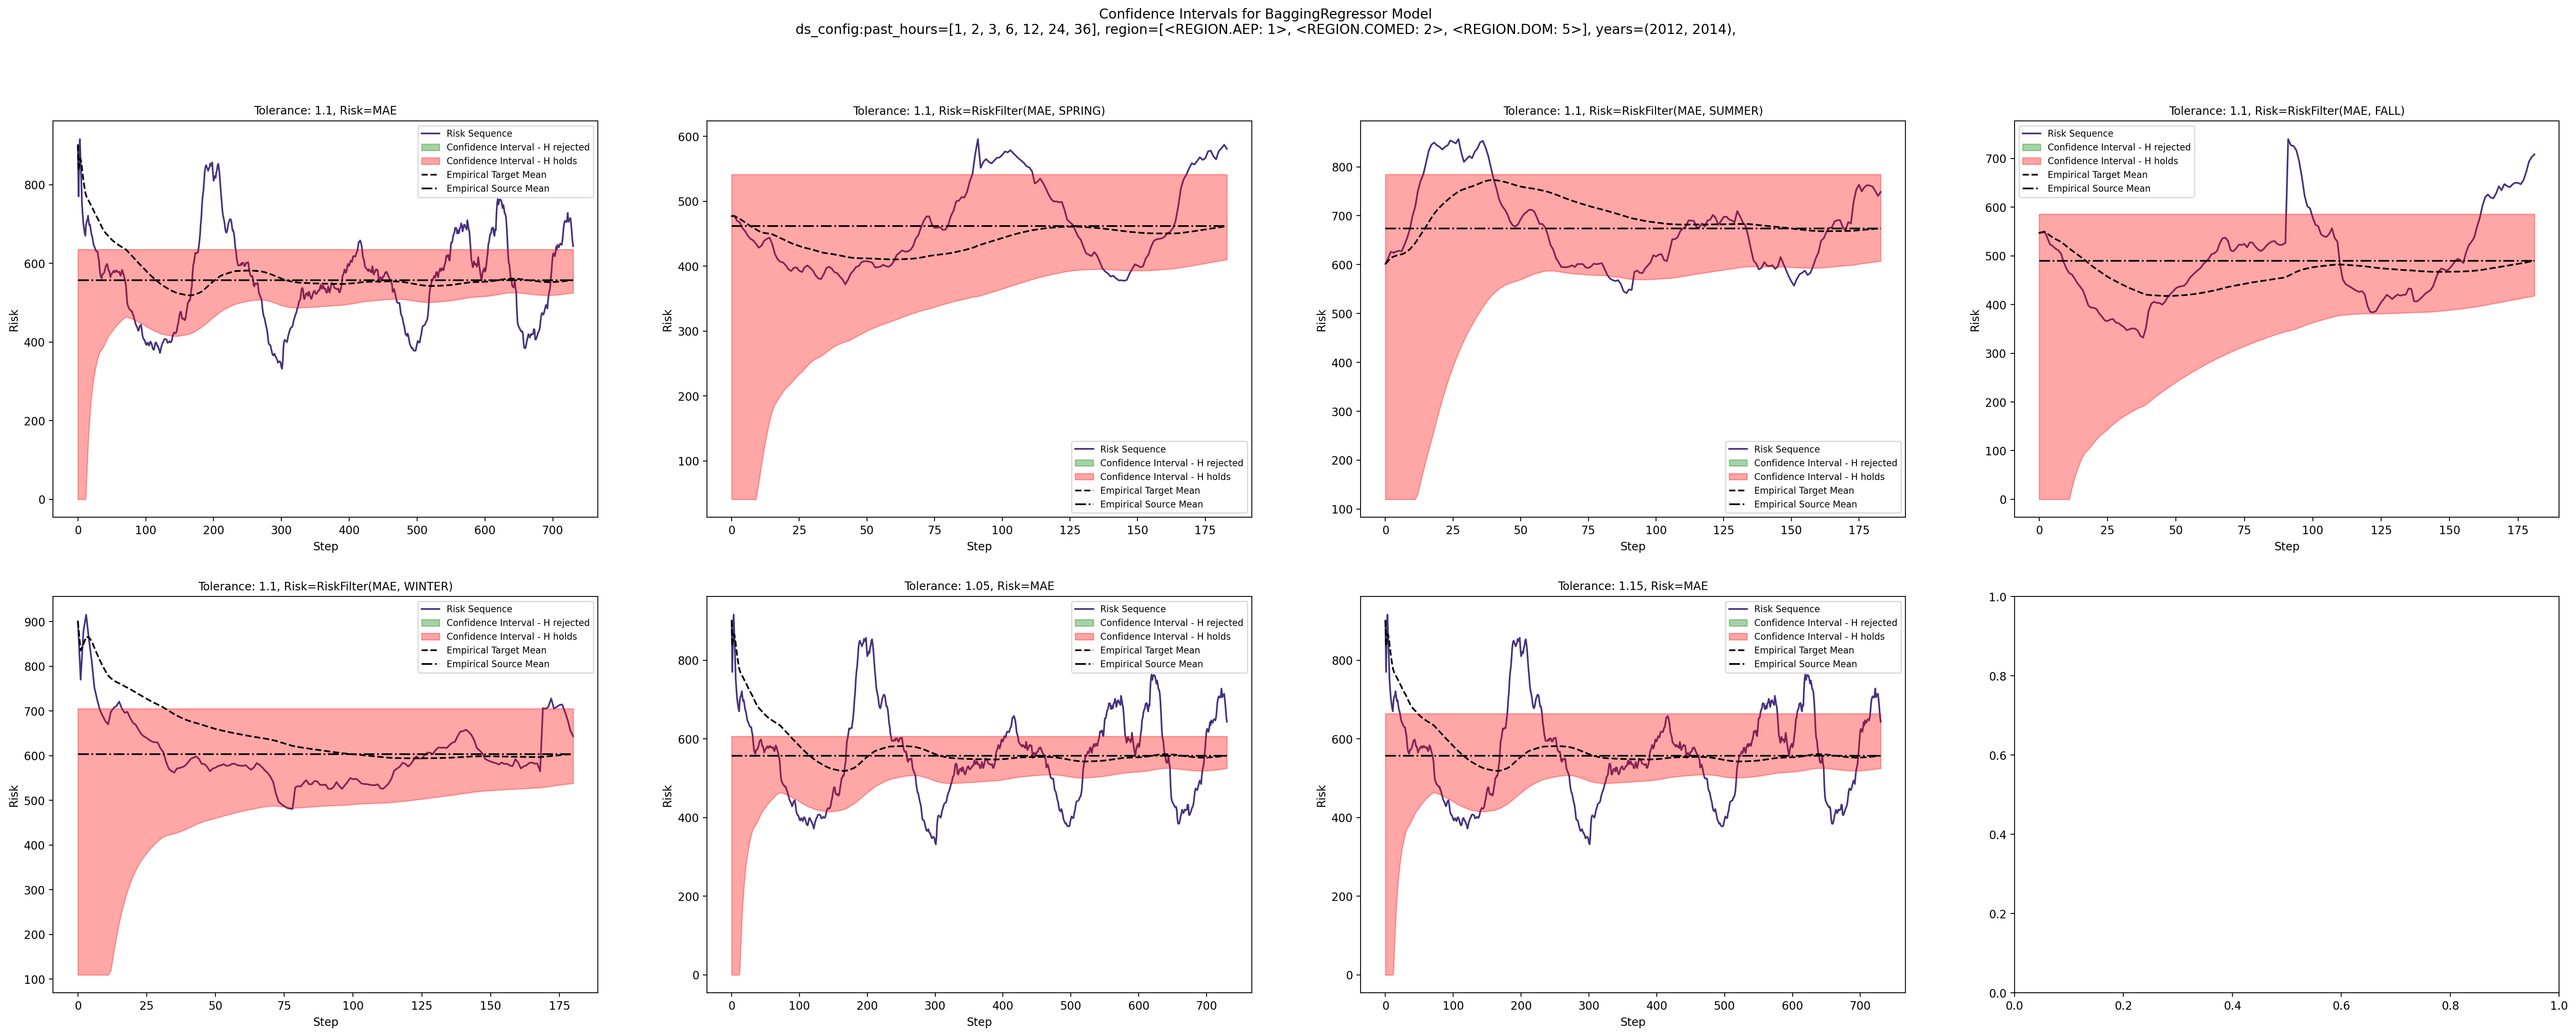

In [36]:
test_result = run_experiment(experiment, train_ds, retrain=False)

Testing:   0%|          | 0/1675 [00:00<?, ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]

Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]

Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using ba

Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using ba

Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

Clipping x to [109.21160125732422, 1287.5319290161133]


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]

Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]

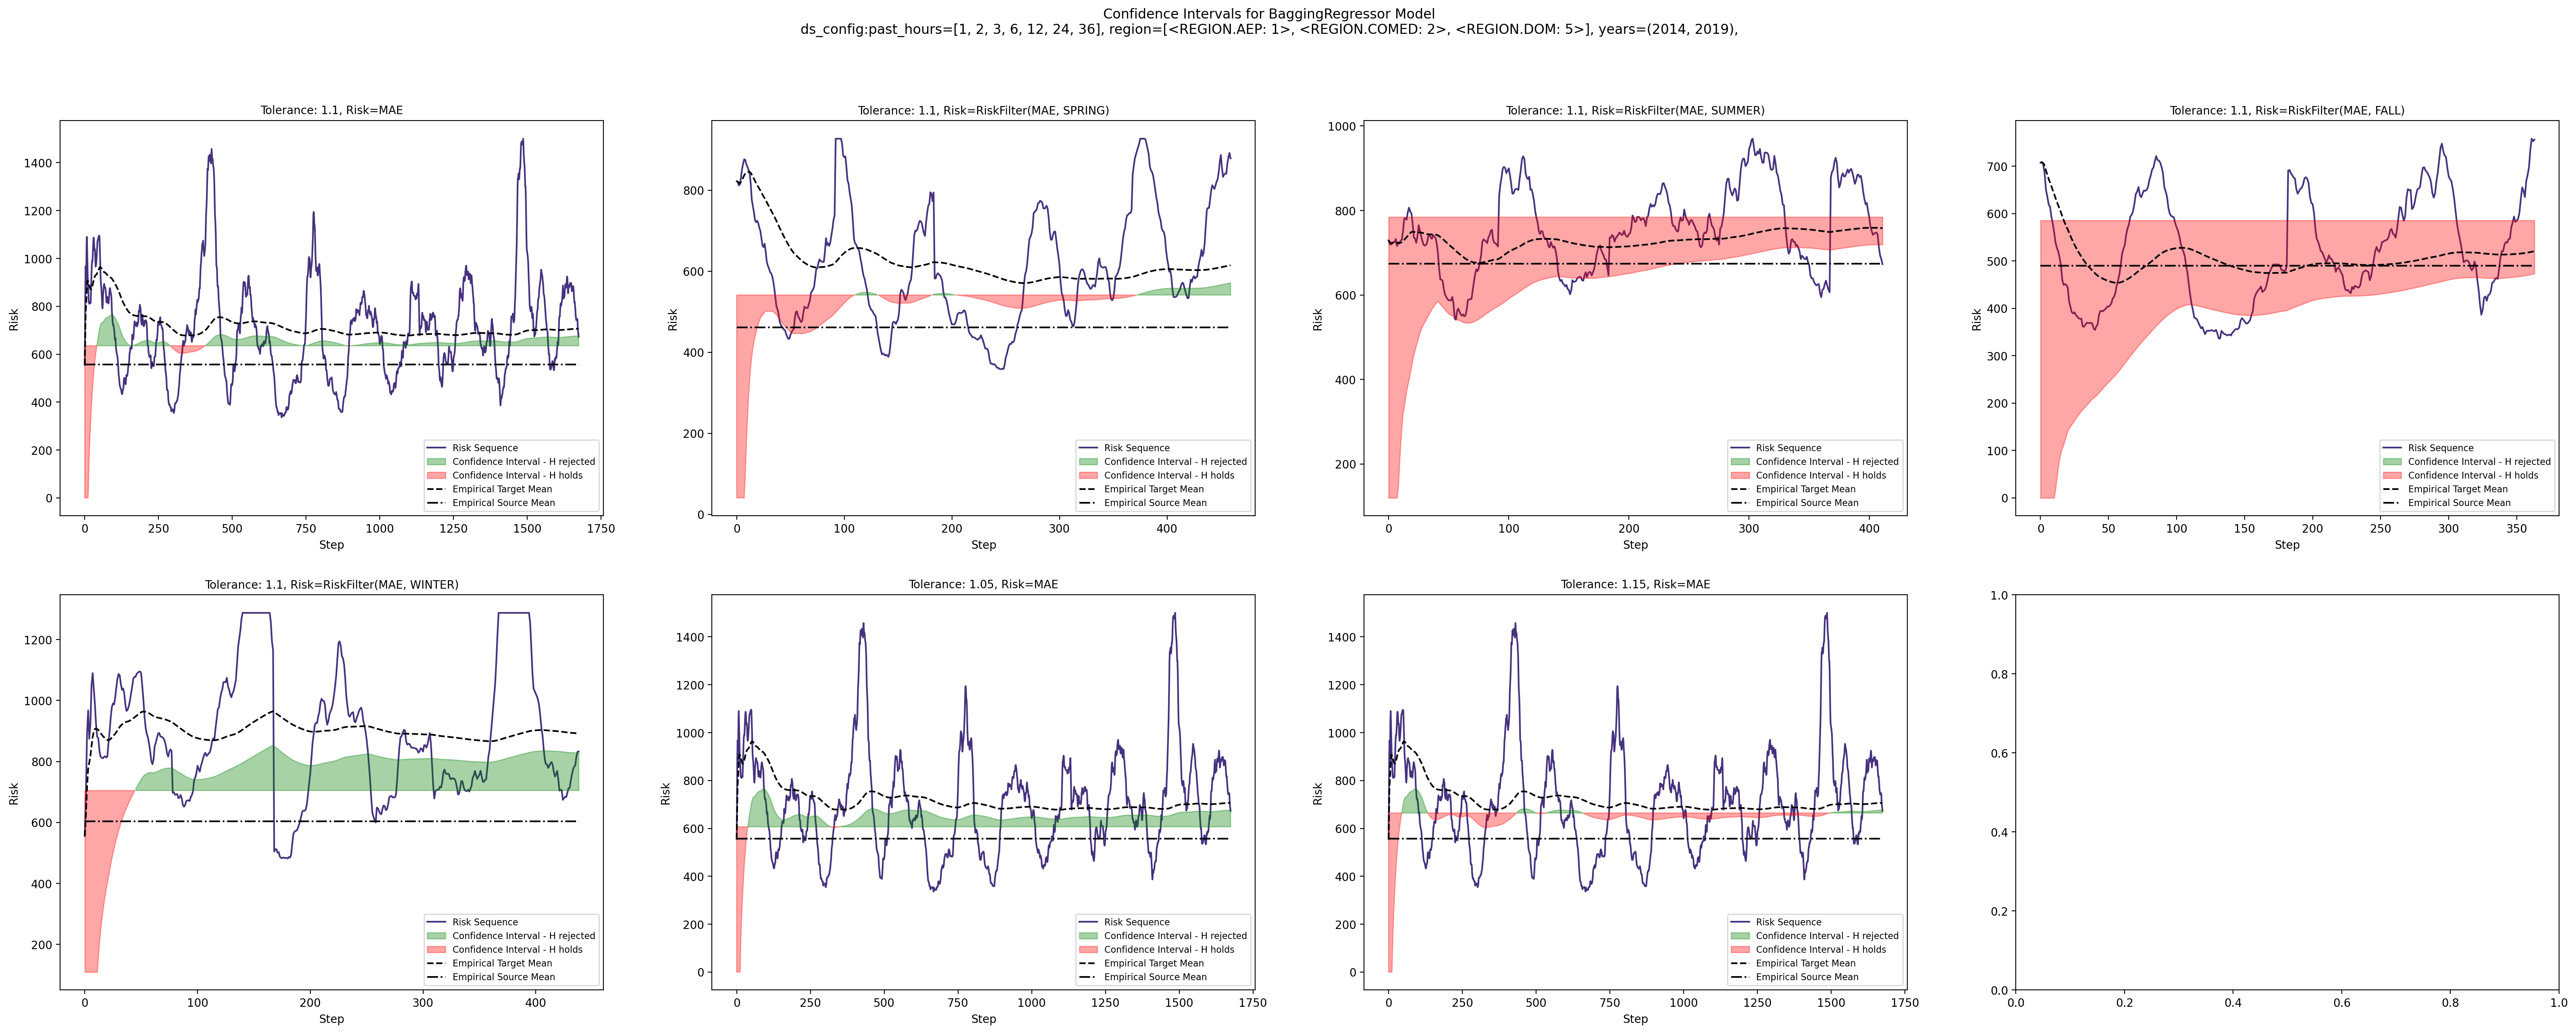

In [37]:
# test_cfg = DatasetConfig(**train_config.__dict__)
# test_cfg.years = (2014, 2019)
# test_ds = EnergyDataset(all_paths, test_cfg)
test_result = run_experiment(experiment, test_ds, retrain=False)

Testing:   0%|          | 0/1675 [00:00<?, ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]

retrain threshold crossed at index:  7128
train_features shape: (56939, 14), train_labels shape: (56939,)
Iteration 1, loss = 9755282.76779320
Iteration 1, loss = 11526732.81793978
Iteration 1, loss = 98376716.11071987
Iteration 1, loss = 38240539.04361297
Iteration 1, loss = 47259647.17610782
Iteration 2, loss = 797991.49409655
Iteration 3, loss = 658467.71035542
Iteration 2, loss = 878047.24118425
Iteration 2, loss = 7275894.03508218
Iteration 2, loss = 8340780.23251659
Iteration 2, loss = 937202.49089442
Iteration 4, loss = 642841.78132834
Iteration 5, loss = 635249.52653373
Iteration 3, loss = 731662.67920671
Iteration 3, loss = 1108768.18522315
Iteration 3, loss = 4279378.04915365
Iteration 3, loss = 756407.30075886
Iteration 6, loss = 626249.96584929
Iteration 7, loss = 615957.29247521
Iteration 4, loss = 714622.37618178
Iteration 4, loss = 907465.62870433
Iteration 4, loss = 2169930.46885084
Iteration 4, loss = 693229.46301364
Iteration 8, loss = 606372.83725458
Iteration 9, los

/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 55, loss = 341930.56533306
Iteration 55, loss = 300643.04054980
Iteration 54, loss = 302649.04384495
Iteration 54, loss = 703384.70286989
Iteration 55, loss = 302140.73995641
Iteration 55, loss = 703369.87144016
Iteration 56, loss = 339071.47337364
Iteration 56, loss = 299327.28914266
Iteration 56, loss = 301667.83213978
Iteration 56, loss = 703355.22970907
Iteration 57, loss = 336618.37325196
Iteration 57, loss = 301129.81812341
Iteration 57, loss = 703340.75496261
Iteration 57, loss = 298085.38940463
Iteration 58, loss = 703326.43177749
Iteration 58, loss = 300607.05088651
Iteration 58, loss = 334446.53754701
Iteration 58, loss = 296917.44024805
Iteration 59, loss = 703312.27522904
Iteration 59, loss = 300090.59604372
Iteration 60, loss = 703298.03404618
Iteration 60, loss = 299619.59529820
Iteration 59, loss = 332585.19914782
Iteration 59, loss = 295662.58151883
Iteration 61, loss = 703285.53363198
Iteration 61, loss = 299103.46809775
Iteration 62, loss = 703270.66763356
I

/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   17.6s remaining:   26.4s
/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 81, loss = 312533.43849537
Iteration 81, loss = 280812.99100288
Iteration 82, loss = 311800.73709229
Iteration 82, loss = 280351.23798730
Iteration 83, loss = 311062.86793185
Iteration 83, loss = 279895.66152250
Iteration 84, loss = 310329.44204899
Iteration 84, loss = 279434.45511493
Iteration 85, loss = 309610.88645552
Iteration 85, loss = 279013.08413376
Iteration 86, loss = 308581.96894842
Iteration 86, loss = 278574.51983112
Iteration 87, loss = 306733.69982543
Iteration 87, loss = 278158.52231597
Iteration 88, loss = 301672.41040532
Iteration 88, loss = 277743.22894035
Iteration 89, loss = 295016.67902567
Iteration 89, loss = 277372.49979355
Iteration 90, loss = 286056.72395031
Iteration 90, loss = 276958.25433106
Iteration 91, loss = 282901.77437736
Iteration 91, loss = 276571.61892495
Iteration 92, loss = 281293.52262442
Iteration 92, loss = 276176.91277647
Iteration 93, loss = 280314.10307625
Iteration 93, loss = 275775.83513997
Iteration 94, loss = 279492.17518337
I

/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   20.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Retrained Model with new data 


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

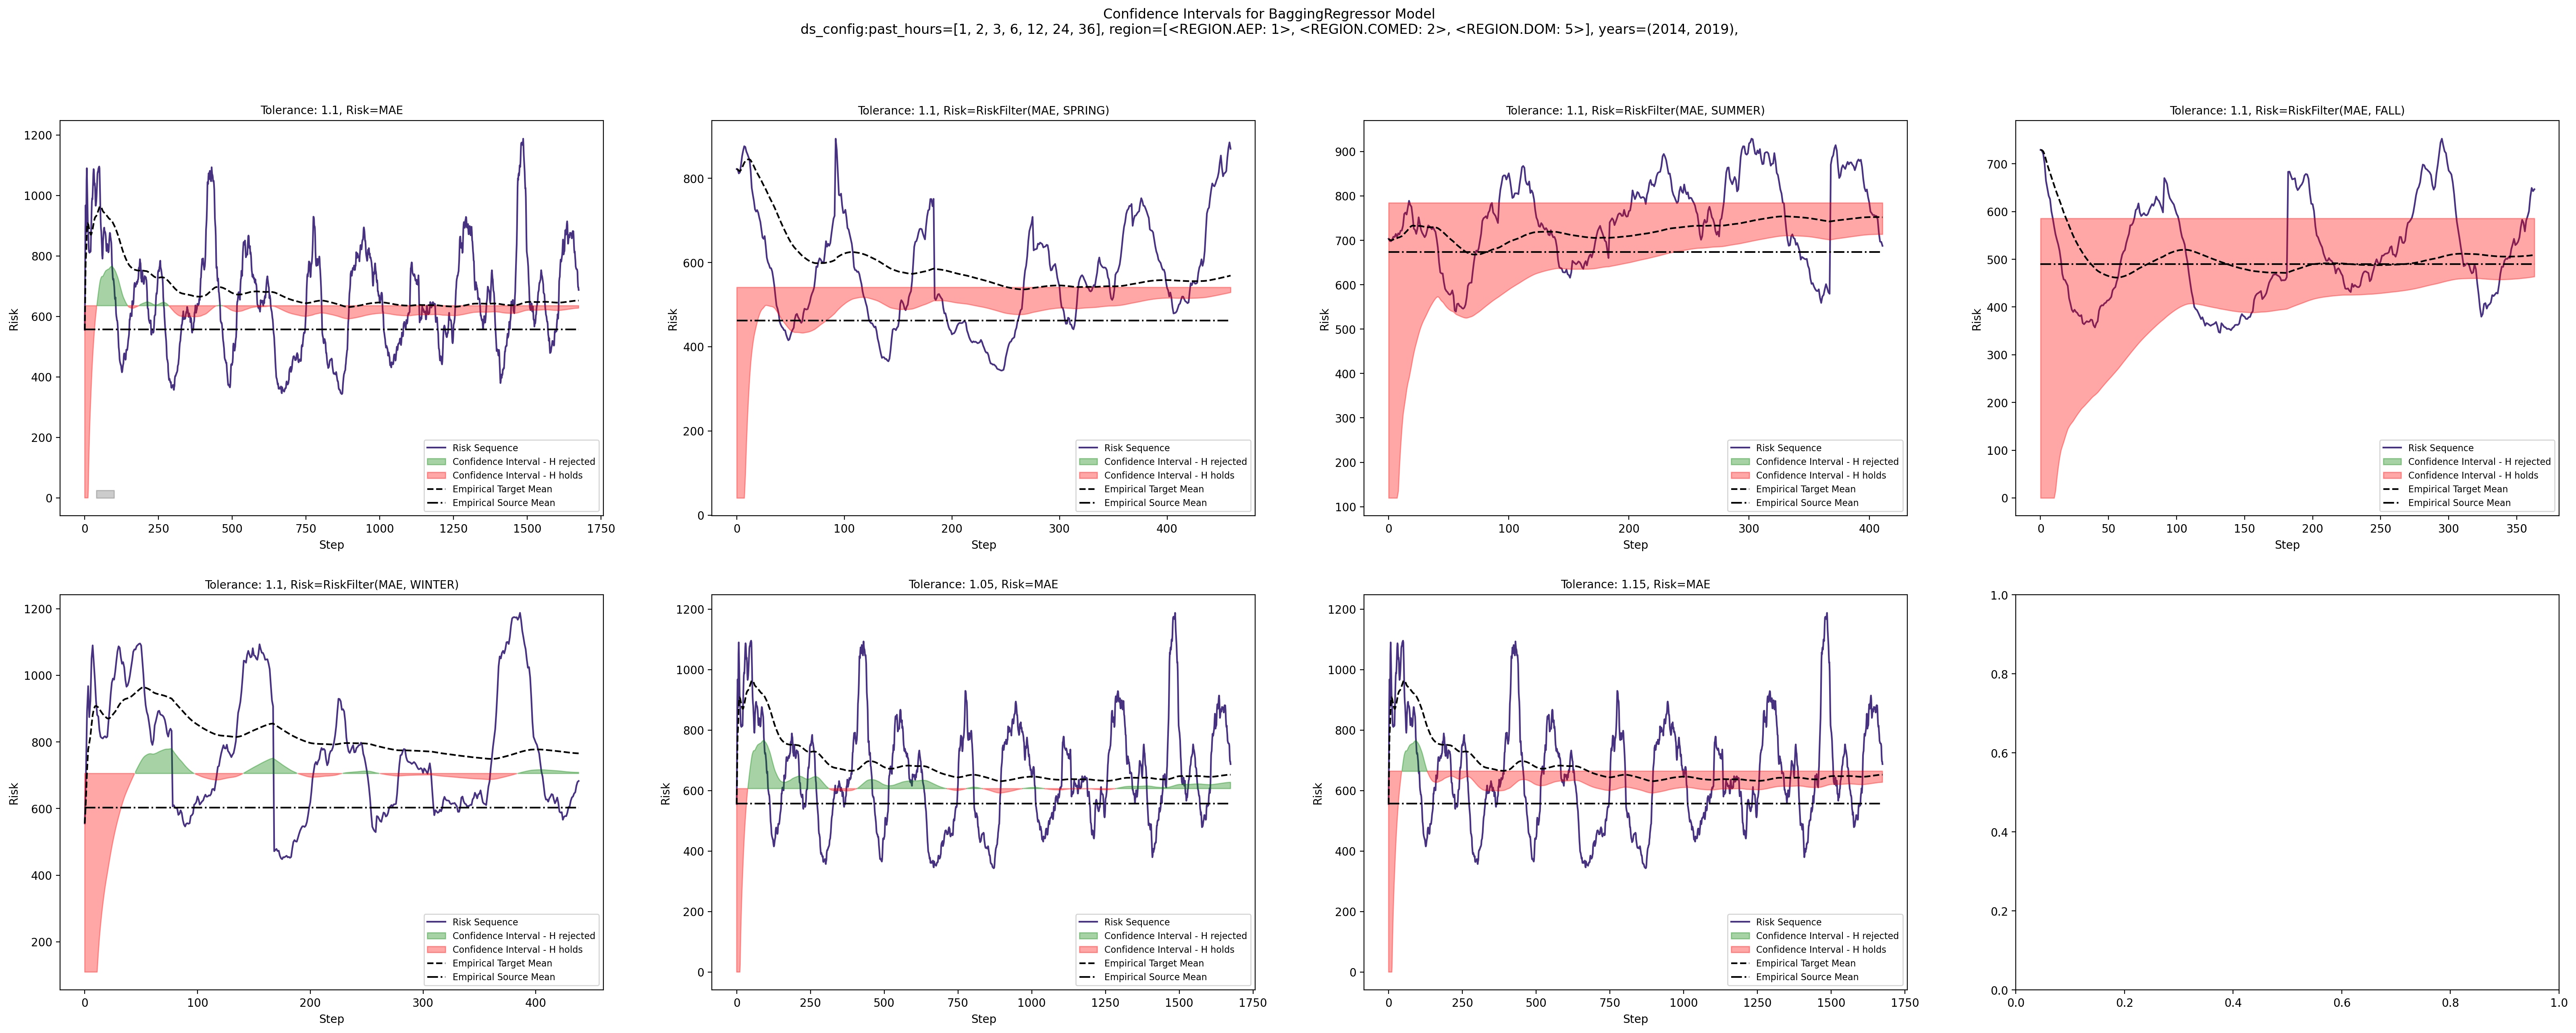

In [38]:
# test_cfg = DatasetConfig(**train_config.__dict__)
# test_cfg.years = (2014, 2019)
# test_ds = EnergyDataset(all_paths, test_cfg)
test_result = run_experiment(experiment, test_ds, retrain=True)